In [47]:
!pip install torchsummary
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
import pandas as pd

### Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [23]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [24]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [25]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

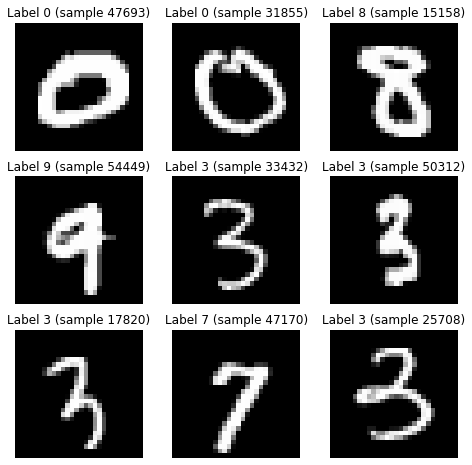

In [26]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [27]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [28]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


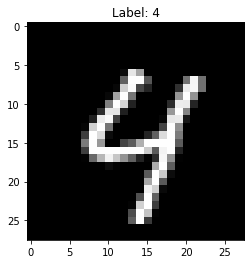

In [29]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [30]:
import torch.nn.functional as F

def linear_trsf(x, W, b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    #print(f'number of classes {nb}')
    x1 = x.view(nb, -1)
    return x1@W.T+b
    # YOUR CODE (END)


def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    x_exp = torch.exp(z)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)

    return x_exp/x_exp_sum
    # YOUR CODE (END)


def predict(x, W, b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    z = linear_trsf(x, W, b)
    #print(z.shape)
    return softmax(z)
    # YOUR CODE (END)

##### TEST

In [31]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0


#### Loss Function

In [32]:
import torch.nn.functional as F

In [33]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)

    nb = y.shape[0]
    #print(f'number of batch examples {nb}')
    return -torch.log(uhat[torch.arange(nb), y[:]])
    
    # YOUR CODE (END)
    
def cost_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)
    return torch.mean(loss_ce(y, uhat))
    # YOUR CODE (END)


##### TEST

In [34]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### Gradient Descent for the given Model

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [35]:
def grad_loss_ce(x, u, uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    #print(x.shape)
    #print(u.shape)
    gradW = torch.mean((uhat-u).view(-1,10,1)*x.view(-1,1,28*28), dim=0)
    gradb = torch.mean((uhat-u), dim=0)
    return gradW, gradb
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [36]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)
    uhat = predict(X,W,b)
    cost = torch.sum(cost_ce(Y, uhat))

    u = F.one_hot(Y, num_classes=10)
    
    correct_predictions = (uhat.argmax(dim=1) == u.argmax(dim=1)).sum().item()

    acc = correct_predictions / Y.shape[0]
    #print(f'{correct_predictions}/{Y.shape[0]}')
    

    return cost, acc
    # YOUR CODE (END)

### Mini-Batch Gradient Descent

In [37]:
nepochs = 10
alpha = 0.1
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist: list = []
acc_hist: list = []
cost_hist_test: list = []
acc_hist_test: list = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest, Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True)))

# initial parameters
W, b = torch.randn((10, 28*28)), torch.zeros((1, 10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    acc = 0
    for X, Y in train_dataloader:
        # step
        uhat = predict(X, W, b)
        
        # u = F.one_hot(Y, num_classes=nclasses)
        u = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses)).float()
        dW, db = grad_loss_ce(X, u, uhat)
        W = W - alpha * dW
        b = b - alpha * db
    
    cost, acc = metrics(X, Y, W, b)
    cost_hist.append(cost)
    acc_hist.append(acc)

    cost_test, acc_test = metrics(Xtest, Ytest, W, b)
    cost_hist_test.append(cost_test)
    acc_hist_test.append(acc_test)

    print("Epoch %i: %f, %f, %f, %f" % (epoch, cost, acc, cost_test, acc_test))

d = datetime.now()
print((d-d0).total_seconds()/nepochs)

Epoch 0: 1.022142, 0.687500, 0.946747, 0.808000
Epoch 1: 0.391243, 0.906250, 0.725969, 0.846900
Epoch 2: 0.430934, 0.906250, 0.634497, 0.862200
Epoch 3: 0.193225, 0.937500, 0.580449, 0.869600
Epoch 4: 0.721058, 0.750000, 0.545640, 0.875500
Epoch 5: 0.619724, 0.906250, 0.511087, 0.881600
Epoch 6: 0.344323, 0.937500, 0.490065, 0.884800
Epoch 7: 0.486109, 0.875000, 0.476663, 0.887000
Epoch 8: 0.382136, 0.906250, 0.461413, 0.890000
Epoch 9: 0.073396, 1.000000, 0.449310, 0.891800
5.061633


Text(0.5, 1.0, 'Accuracy')

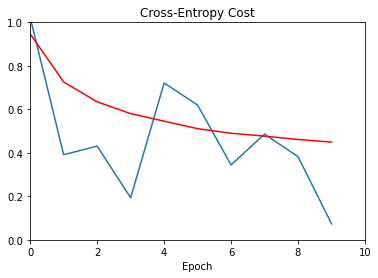

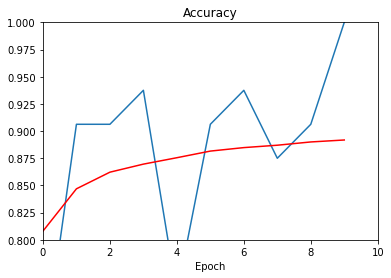

In [38]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### With Full-Fledge PyTorch

In [18]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28,10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z


In [19]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [20]:
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [21]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
nbatches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        cost = cost_ce(pred, Y)
        acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        # gradient, parameter update
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    # cost /= nbatches
    acc /= size
    
    cost_test, acc_test = 0.0, 0.0
    with torch.no_grad():
        for X, Y, in test_loader:
            pred = model(X)
            cost_test = cost_ce(pred, Y)
            acc_test = (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
    cost_test /= len(test_loader)
    acc_test /= len(test_loader.dataset)

    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost.detach().numpy())
    cost_hist_test.append(cost_test.detach().numpy())
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)

Epoch 0: 0.554747, 0.805717, 0.600545, 0.866800
Epoch 1: 0.493922, 0.867033, 0.476232, 0.882600
Epoch 2: 0.327258, 0.879383, 0.426370, 0.890000
Epoch 3: 0.484641, 0.886467, 0.397703, 0.896300
Epoch 4: 0.518491, 0.890983, 0.379227, 0.899500
Epoch 5: 0.259817, 0.894050, 0.366079, 0.902900
Epoch 6: 0.501299, 0.896950, 0.355095, 0.905000
Epoch 7: 0.330016, 0.898900, 0.347183, 0.906600
Epoch 8: 0.476652, 0.901150, 0.340102, 0.907500
Epoch 9: 0.182338, 0.902417, 0.334959, 0.909500


Text(0.5, 1.0, 'Accuracy')

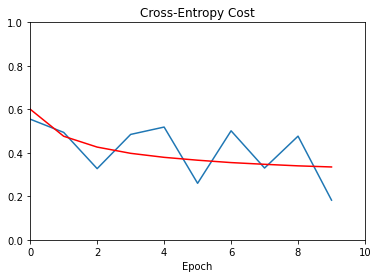

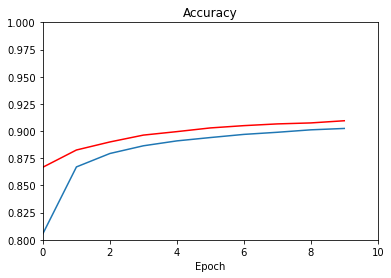

In [22]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")

### Analysis of different settings for learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Can you explain the behavior?

## Answer
It looks like the learning is faster when using a smaller batch size which is reasonable because the weights and bias are updated every time the a batch is done. So this means the epochs or the learning rate could be decreased.

If the batch size gets to big, we have to use a bigger learning rate $\alpha$ or more epochs as the weights are updated less frequently. 
This has the side effect, that we use more time and ressources to train our systems.

If we use a very small batch size instead we have a very unstable learning during the beginning of the learning as we only see a small set of our training data.

There is the possibility that we even use a smaller learning rate $\alpha$ and increase the epochs to get proper results.

It is also nice to see how the CE-Costs are getting more stable when using a bigger batchsize.

### Takeaway
It is always a tradeoff between these three hyperparameters to get proper results. So take enought time into hyperparameter-testing

Training for Batch Size 32 and Alpha 0.05 with 10 epochs
Epoch 0: 0.223201, 0.876100, 0.338240, 0.907100
Epoch 1: 0.167334, 0.905483, 0.306211, 0.916000
Epoch 2: 0.263684, 0.911833, 0.293889, 0.917400
Epoch 3: 0.155791, 0.914917, 0.287668, 0.920400
Epoch 4: 0.176499, 0.917367, 0.283641, 0.921100
Epoch 5: 0.255149, 0.919150, 0.280770, 0.920500
Epoch 6: 0.091504, 0.920667, 0.279374, 0.922200
Epoch 7: 0.395856, 0.921617, 0.277971, 0.923500
Epoch 8: 0.302142, 0.922917, 0.276687, 0.921000
Epoch 9: 0.186247, 0.923600, 0.273954, 0.921800
Training for Batch Size 32 and Alpha 0.1 with 10 epochs
Epoch 0: 0.828809, 0.889017, 0.314530, 0.911100
Epoch 1: 0.341795, 0.912050, 0.289488, 0.918600
Epoch 2: 0.350958, 0.916917, 0.281573, 0.921300
Epoch 3: 0.201794, 0.919667, 0.277995, 0.920900
Epoch 4: 0.268281, 0.921450, 0.280188, 0.924000
Epoch 5: 0.189068, 0.923367, 0.272081, 0.924100
Epoch 6: 0.238220, 0.923550, 0.274012, 0.921400
Epoch 7: 0.166584, 0.924383, 0.278099, 0.921900
Epoch 8: 0.195154, 0.92

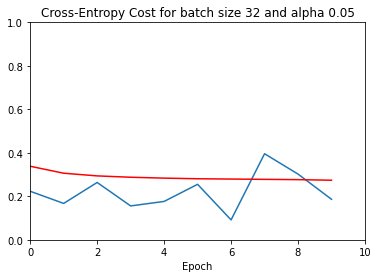

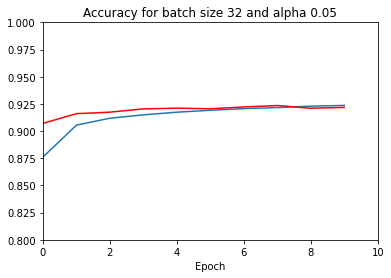

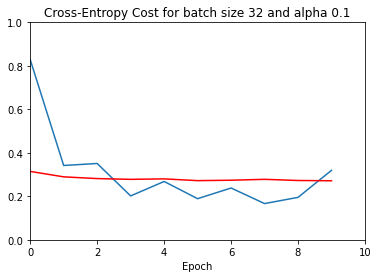

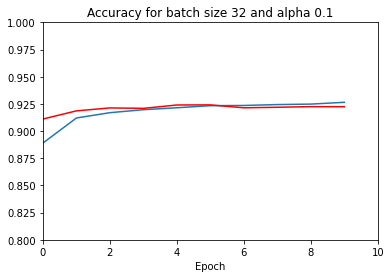

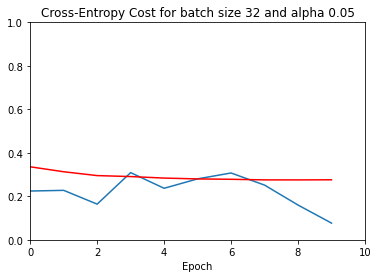

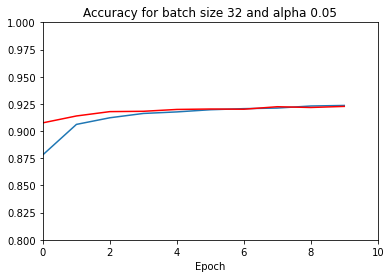

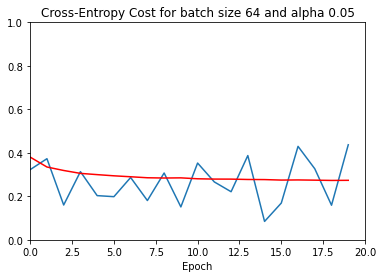

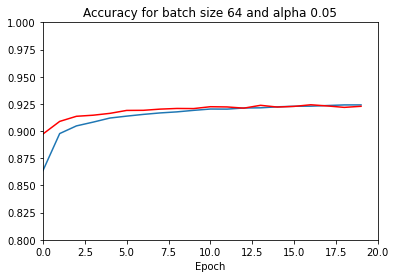

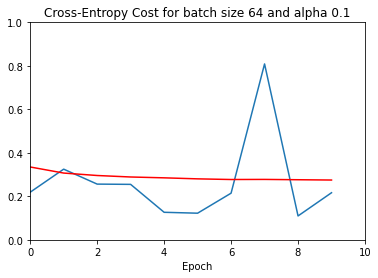

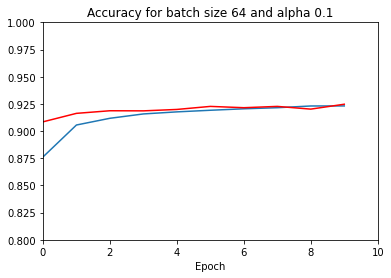

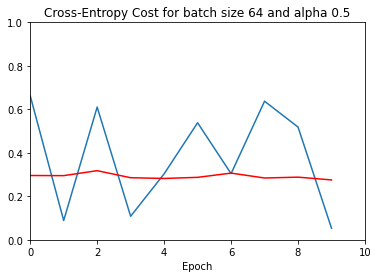

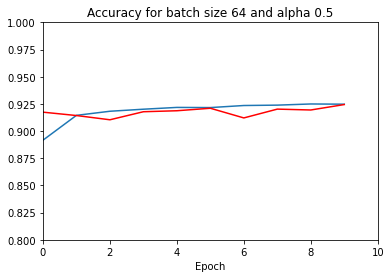

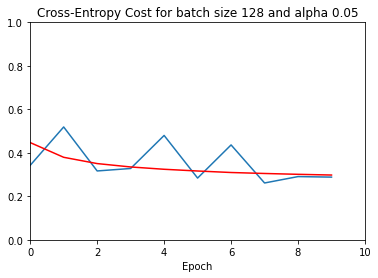

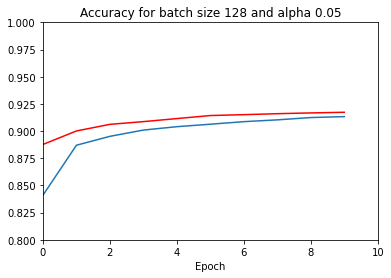

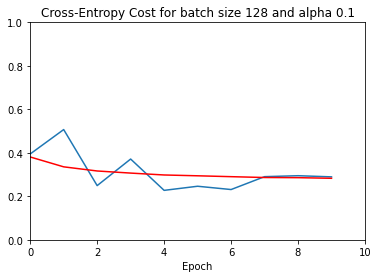

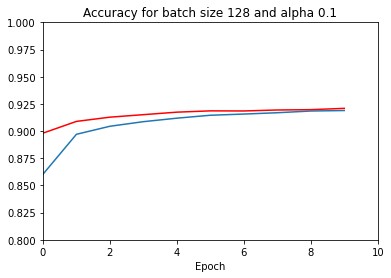

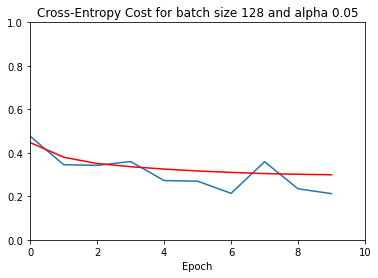

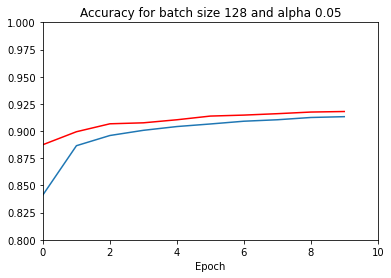

In [82]:
array = []
settings = [(32,0.05,10),(32,0.1,10),(32,0.05,10),(64,0.05,20),(64,0.1,10),(64,0.5,10),(128,0.05,10),(128,0.1,10),(128,0.05,10)]
i = 1
for setting in settings:
    model = NeuralNetwork()
    #print(model)
    print(f"Training for Batch Size {setting[0]} and Alpha {setting[1]} with {setting[2]} epochs")
    nbatch = setting[0]
    nepochs = setting[2]
    learning_rate = setting[1]

    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
    Xtest, Ytest = next(iter(test_loader))
    size = len(training_loader.dataset)
    nbatches = len(training_loader)

    for epoch in range(nepochs):
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            cost = cost_ce(pred, Y)
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

            # gradient, parameter update
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        # cost /= nbatches
        acc /= size

        cost_test, acc_test = 0.0, 0.0
        with torch.no_grad():
            for X, Y, in test_loader:
                pred = model(X)
                cost_test = cost_ce(pred, Y)
                acc_test = (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= len(test_loader)
        acc_test /= len(test_loader.dataset)

        print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost.detach().numpy())
        cost_hist_test.append(cost_test.detach().numpy())
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
        
    array.append({'BatchSize':nbatch, 'LearningRate': learning_rate, 'Epochs':nepochs, 'Training_Cost':cost.detach().numpy(), 'Training_Accuracy': acc, 'Test_Cost': cost_test.detach().numpy(), 'Test_Accuracy': acc_test })
    plt.figure(i)
    plt.plot(torch.arange(nepochs), cost_hist, "-")
    plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(0,1)
    plt.title(f"Cross-Entropy Cost for batch size {setting[0]} and alpha {setting[1]}")
    plt.figure(i+1)
    plt.plot(torch.arange(nepochs), acc_hist,"-")
    plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
    plt.xlabel("Epoch")
    plt.xlim(0,nepochs)
    plt.ylim(0.8,1)
    plt.title(f"Accuracy for batch size {setting[0]} and alpha {setting[1]}")
    i = i+2

In [83]:
df = pd.DataFrame(array, columns=["BatchSize", "LearningRate", "Epochs", "Training_Cost", "Training_Accuracy", "Test_Cost", "Test_Accuracy"])
df.head(n=len(settings))

,BatchSize,LearningRate,Epochs,Training_Cost,Training_Accuracy,Test_Cost,Test_Accuracy
0,32,0.05,10,0.1862469,0.923600,0.27395448,0.9218
1,32,0.10,10,0.31961522,0.926467,0.2714769,0.9224
2,32,0.05,10,0.07676484,0.923567,0.27596113,0.9227
3,64,0.05,20,0.43697897,0.924067,0.2735421,0.9228
4,64,0.10,10,0.21646483,0.923133,0.2748725,0.9247
5,64,0.50,10,0.053173386,0.924733,0.27535817,0.9244
6,128,0.05,10,0.2882558,0.913283,0.29784906,0.9173
7,128,0.10,10,0.28945094,0.918900,0.2829058,0.9209
8,128,0.05,10,0.21235484,0.913250,0.29895017,0.9180
